In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE


In [26]:

# 1. Loads the data
df = pd.read_csv("ravdess_features.csv")

# 2.printing the content 
print("📊 Shape of the DataFrame:", df.shape)
print(df.head())

# Stop and warn if it's empty
if df.shape[0] == 0:
    raise ValueError("The CSV file is empty. Check your preprocessing step.")

# 3. Separate features and labels
X = df.drop("label", axis=1)
y = df["label"]

# 4. Convert string labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

import joblib
joblib.dump(le, "label_encoder.pkl")


# 5. 80-20 train-validation split with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"✅ Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)



📊 Shape of the DataFrame: (2452, 61)
            0          1          2         3          4          5  \
0 -570.000305  29.231855 -28.572050 -1.171939  -8.968902 -10.660740   
1 -542.260498  33.782990  -3.803622  3.091985  -9.681706  -6.023739   
2 -687.706604  39.088589  -5.860187  6.923982 -10.534793  -5.880984   
3 -550.819153  37.232449  -5.966861  4.732355  -2.008578  -9.404682   
4 -573.296753  45.841038  -9.815438  4.286420  -8.331691  -3.489434   

           6          7          8         9  ...        51         52  \
0 -13.617955 -19.157396  -4.766867 -3.655524  ...  0.497664  12.476468   
1  -8.644806 -11.424565 -11.615021 -1.289250  ...  0.424412  18.173931   
2  -6.757151  -8.113562  -3.685668 -5.643714  ...  0.371718  16.162948   
3 -14.451254 -14.265596  -8.414461  0.758800  ...  0.399976  16.634672   
4  -5.228768 -11.024238  -5.628939 -1.996801  ...  0.484061  15.979445   

          53         54         55         56         57         58        59  \
0  19.2261

In [27]:
# Define F1 scorer (weighted)
f1_scorer = make_scorer(f1_score, average='weighted')

# Define parameter grid
param_grid = {
    'hidden_layer_sizes': [(256, 64), (128, 64), (64,), (128,)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

# Create GridSearchCV
grid = GridSearchCV(
    MLPClassifier(max_iter=1000, early_stopping=True, random_state=42),
    param_grid=param_grid,
    scoring=f1_scorer,       
    cv=3,                    # 3-fold cross-validation
    verbose=2,
    n_jobs=-1                
)

# Fit the model
grid.fit(X_train_scaled, y_train)

# Show best config
print("Best Parameters:", grid.best_params_)
print("Best Weighted F1 Score:", grid.best_score_)



Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=constant; total time=   0.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=constant; total time=   0.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=adaptive; total time=   0.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=constant; total time=   0.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(256, 64), learning_rate=constant; total time=   0.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(256, 64), learning_rate=constant; total time=   0.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(256, 64), learning_rate=adaptive; total time=   0.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=adaptive; total time=   0.5s
[CV] END activation=relu, alpha=0.


Validation Set Report:
               precision    recall  f1-score   support

       angry       0.79      0.85      0.82        75
        calm       0.77      0.84      0.80        75
     disgust       0.50      0.51      0.51        39
     fearful       0.70      0.65      0.68        75
       happy       0.82      0.60      0.69        75
     neutral       0.69      0.66      0.68        38
         sad       0.68      0.76      0.72        75
   surprised       0.56      0.62      0.59        39

    accuracy                           0.71       491
   macro avg       0.69      0.69      0.68       491
weighted avg       0.71      0.71      0.71       491



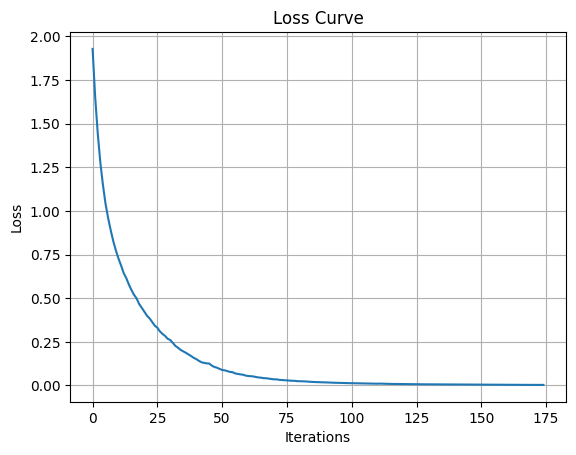

In [28]:

# 3. Retrain best model from scratch on full training set
final_model = MLPClassifier(
    hidden_layer_sizes=(256, 64),
    activation='relu',
    alpha=0.0001,
    learning_rate='constant',
    early_stopping=True,
    max_iter=1000,
    random_state=42
)

final_model.fit(X_train_resampled, y_train_resampled)


# Evaluate best model on validation set


best_model = grid.best_estimator_
y_pred = best_model.predict(X_val_scaled)
print("\nValidation Set Report:\n", classification_report(y_val, y_pred, target_names=le.classes_))


# Initialize and train MLP
mlp = MLPClassifier(hidden_layer_sizes=(256, 64), max_iter=500, random_state=7)
mlp.fit(X_train_scaled, y_train)


plt.plot(mlp.loss_curve_)
plt.title("Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.show()



Accuracy: 0.7861507128309573
F1 Score: 0.7883331766558901

Classification Report:
               precision    recall  f1-score   support

       angry       0.88      0.85      0.86        75
        calm       0.83      0.83      0.83        75
     disgust       0.65      0.72      0.68        39
     fearful       0.85      0.77      0.81        75
       happy       0.87      0.79      0.83        75
     neutral       0.62      0.76      0.68        38
         sad       0.76      0.77      0.77        75
   surprised       0.68      0.72      0.70        39

    accuracy                           0.79       491
   macro avg       0.77      0.78      0.77       491
weighted avg       0.79      0.79      0.79       491



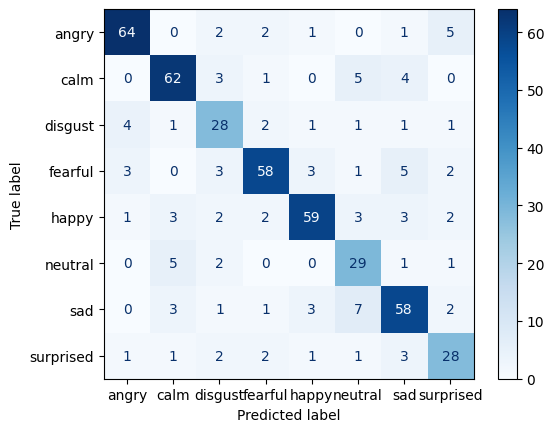

In [29]:
# Predict
y_pred = mlp.predict(X_val_scaled)

# Print metrics
print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_val, y_pred, target_names=le.classes_))
#  Confusion matrix & per-class accuracy
cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot(cmap='Blues')
plt.show()


In [30]:
import joblib
joblib.dump(grid.best_estimator_, "model.pkl")


['model.pkl']